In [1]:
import math
import time
import scipy
import QuantLib
import xlsxwriter
import numpy as np
import pandas as pd
import xlwings as xw
import QuantLib as ql
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
def data_df_to_curve(data_df):
    dates = [ql.Date(i.day, i.month, i.year) for i in list(data_df.index)]
    largo_yf = (dates[-1] - dates[0])/360
    dfs = list(data_df["DF"])
    dayCounter = ql.Actual360()
    curve = ql.DiscountCurve(dates, dfs, dayCounter)
    return curve, largo_yf

In [3]:
file_name = "datosbbg_curvas.xlsx"
col_names = ['Dates', 'Years', 'DF', 'Zero']

ois_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'A,B,C,D', skiprows = [0], names = col_names, index_col = 0)
libor3m_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'F,G,H,I', skiprows = [0], names = col_names, index_col = 0)
libor6m_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'K,L,M,N', skiprows = [0], names = col_names, index_col = 0)
coll_usd_clp_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'P,Q,R,S', skiprows = [0], names = col_names, index_col = 0)
icp_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'U,V,W,X', skiprows = [0], names = col_names, index_col = 0)
coll_usd_uf_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'Z,AA,AB,AC', skiprows = [0], names = col_names, index_col = 0)

# Sacamos ultimas filas sin datos
ois_data = ois_data[ois_data['Years'].notnull()]
libor3m_data = libor3m_data[libor3m_data['Years'].notnull()]
libor6m_data = libor6m_data[libor6m_data['Years'].notnull()]
coll_usd_clp_data = coll_usd_clp_data[coll_usd_clp_data['Years'].notnull()]
icp_data = icp_data[icp_data['Years'].notnull()]
coll_usd_uf_data = coll_usd_uf_data[coll_usd_uf_data['Years'].notnull()]

curves = {"ois": data_df_to_curve(ois_data), 
          "libor3m": data_df_to_curve(libor3m_data),
          "libor6m": data_df_to_curve(libor6m_data),
          "coll_usd_clp": data_df_to_curve(coll_usd_clp_data),
          "icp": data_df_to_curve(icp_data),
          "coll_usd_uf": data_df_to_curve(coll_usd_uf_data)}

In [4]:
class HullWhite:
    
    def __init__(self, a, sigma, curve, r0, nro_simu):
        self.sigma = sigma
        self.a = a
        self.curve = curve[0]
        self.T = curve[1]
        self.r0 = r0
        self.nro_simu = nro_simu
        self.dt = 1/12
        self.nro_periodos = int(self.T/self.dt) + 1
        self.epsilon = self.dt
        self.t_lim = (self.nro_periodos-1)*self.dt
        self.media_movil = 10
        self.tolerancia = 10**(-4)
        
    def funcion_M(self, T):
        if T >= self.t_lim:
            valor = -(math.log(self.curve.discount(T)) - math.log(self.curve.discount(T-self.epsilon)))/self.epsilon
        else:
            valor = -(math.log(self.curve.discount(T + self.epsilon)) - math.log(self.curve.discount(T)))/self.epsilon
        return valor
    
    def derivada_funcion_M(self, T):
        if T >= self.t_lim:
            valor = (self.funcion_M(T) - self.funcion_M(T-self.epsilon))/self.epsilon
        else:
            valor = (self.funcion_M(T+self.epsilon) - self.funcion_M(T))/self.epsilon
        return valor
    
    def theta_t(self, t):
        valor_1 = self.derivada_funcion_M(t) + self.a*self.funcion_M(t) 
        valor_2 = ((self.sigma**2)/(2*self.a))*(1-math.exp(-2*self.a*t))
        valor = valor_1 + valor_2
        return valor
    
    def creacion_theta(self):
        self.tiempos = []
        for i in range(self.nro_periodos):
            self.tiempos.append(i*self.dt)
        self.theta = []
        for t in self.tiempos:
            self.theta.append(self.theta_t(t))
    
    def graficar_theta(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos, self.theta, lw = 0.8, alpha = 0.6, color = "red")
    
    def B(self, t, T):
        valor = (1/self.a)*(1-math.exp(-self.a*(T-t)))
        return valor
    
    def A(self, t, T):
        fraccion = self.curve.discount(T)/self.curve.discount(t)
        exponente = self.B(t, T)*self.funcion_M(t) - ((self.sigma**2)/(4*self.a))*(1-math.exp(-2*self.a*t))*((self.B(t,T))**2)
        valor = fraccion*math.exp(exponente)
        return valor
    
    def crear_matriz_A_B(self):
        self.matriz_A = []
        self.matriz_B = []
        for i in range(self.nro_periodos):
            fila_A = []
            fila_B = []
            for j in range(self.nro_periodos):
                if i<=j:
                    t = i*self.dt
                    T = j*self.dt
                    fila_A.append(self.A(t, T))
                    fila_B.append(self.B(t, T))
                else:
                    fila_A.append(0)
                    fila_B.append(0)
            self.matriz_A.append(fila_A)
            self.matriz_B.append(fila_B)
    
    def creating_path(self):
        dW = []
        for k in range(self.nro_periodos):
            dW.append(np.random.normal(0, 1, 1))
        r = [self.r0]
        for i in range(self.nro_periodos):
            r.append(r[i] + (self.theta[i] - self.a*r[i])*self.dt + self.sigma*dW[i]*math.sqrt(self.dt))
        return r
    
    def creacion_simulacion(self):
        self.path = []
        for i in range(self.nro_simu):
            self.path.append(self.creating_path())
        self.max_path = []
        self.min_path = []
        self.p_75_path = []
        self.p_50_path = []
        self.p_25_path = []
        for i in range(self.nro_periodos + 1):
            lista = []
            for j in range(self.nro_simu):
                lista.append(self.path[j][i])
            self.max_path.append(max(lista))
            self.min_path.append(min(lista))
            self.p_75_path.append(np.percentile(lista, 75))
            self.p_50_path.append(np.percentile(lista, 50))
            self.p_25_path.append(np.percentile(lista, 25))
    
    def graficar_simulaciones(self):
        fig, ax = plt.subplots(figsize=(17,10))
        self.nuevos_tiempos = []
        for i in range(len(self.path[0])):
            self.nuevos_tiempos.append(i*self.dt)
        for k in self.path:
            ax.plot(self.nuevos_tiempos, k, lw = 0.8, alpha = 0.6)
    
    def graficar_percentiles_simu(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.nuevos_tiempos, self.max_path, lw = 0.8, alpha = 0.6, color = "green")
        ax.plot(self.nuevos_tiempos, self.min_path, lw = 0.8, alpha = 0.6, color = "green")
        ax.plot(self.nuevos_tiempos, self.p_25_path, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.nuevos_tiempos, self.p_75_path, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.nuevos_tiempos, self.p_50_path, lw = 0.8, alpha = 0.6, color = "blue")
    
    def curvas_descuento(self):
        self.curvas_descuento_todas = []
        for i in range(self.nro_simu):
            curvas_sim = []
            for j in range(self.nro_periodos):
                curva = []
                for k in range(j, self.nro_periodos):
                    curva.append(self.matriz_A[j][k]*math.exp(-self.matriz_B[j][k]*self.path[i][j]))
                curvas_sim.append(curva)
            self.curvas_descuento_todas.append(curvas_sim)
            
    def curva_descuento_media(self):
        self.curva_media = []
        for i in range(self.nro_periodos):
            curva = []
            for j in range(i, self.nro_periodos):
                curva.append(self.matriz_A[i][j]*math.exp(-self.matriz_B[i][j]*self.p_50_path[i]))
            self.curva_media.append(curva)
    
    def graficar_curvas_descuento_media(self):
        fig, ax = plt.subplots(figsize=(17,10))
        for i in range(len(self.curva_media)):
            ax.plot(self.tiempos[i:len(self.nuevos_tiempos)], self.curva_media[i], lw = 0.8, alpha = 0.6)
    
    def curva_descuentos_aproximada(self):
        curvas_totales = []
        for i in range(len(self.path)):
            nueva_curva = []
            suma = 0
            for j in range(len(self.path[0])):
                suma = suma + self.path[i][j]
                nueva_curva.append(math.exp(-suma*self.dt))
            curvas_totales.append(nueva_curva)
        self.curva_descuentos_aproximada = []
        for t in range(len(curvas_totales[0])):
            lista = []
            for p in range(len(curvas_totales)):
                lista.append(curvas_totales[p][t])
            media = np.mean(lista)
            self.curva_descuentos_aproximada.append(media)
    
    def graficar_curvas_descuento_aproximada(self):
        fig, ax = plt.subplots(figsize=(17,10))
        grafico_1, = ax.plot(self.nuevos_tiempos, self.curva_descuentos_aproximada, lw = 0.8, alpha = 0.6, color = "red")
        grafico_2, = ax.plot(self.tiempos, self.curva_media[0], lw = 0.8, alpha = 0.6, color = "blue")
        self.curva_dada = []
        for t in self.tiempos:
            self.curva_dada.append(self.curve.discount(t))
        grafico_3, = ax.plot(self.tiempos, self.curva_dada, lw = 0.8, alpha = 0.6, color = "green")  
        grafico_1.set_label("Curva aproximada")
        grafico_2.set_label("Curva simulada")
        grafico_3.set_label("Curva dada")
        ax.legend()
        
    def calcular_error(self):
        error = 0
        for i in range(len(self.tiempos)):
            error = error + abs(self.curva_media[0][i] - self.curva_descuentos_aproximada[i])
        return error/len(self.tiempos)

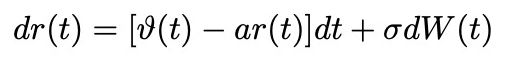

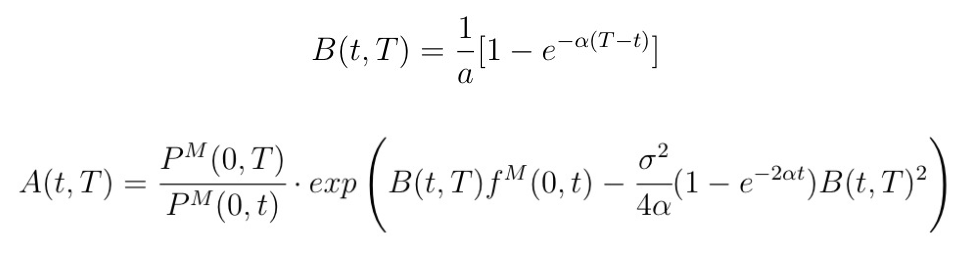

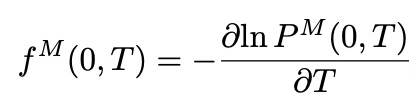

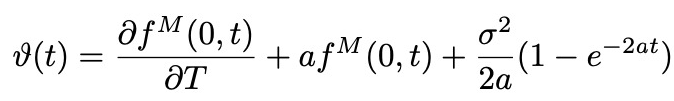

In [5]:
a = 0.2
sigma = 0.0036
curve = curves["ois"]
r0 = 0.050012/100
nro_simu = 100

HW = HullWhite(a, sigma, curve, r0, nro_simu)

In [6]:
HW.creacion_theta()

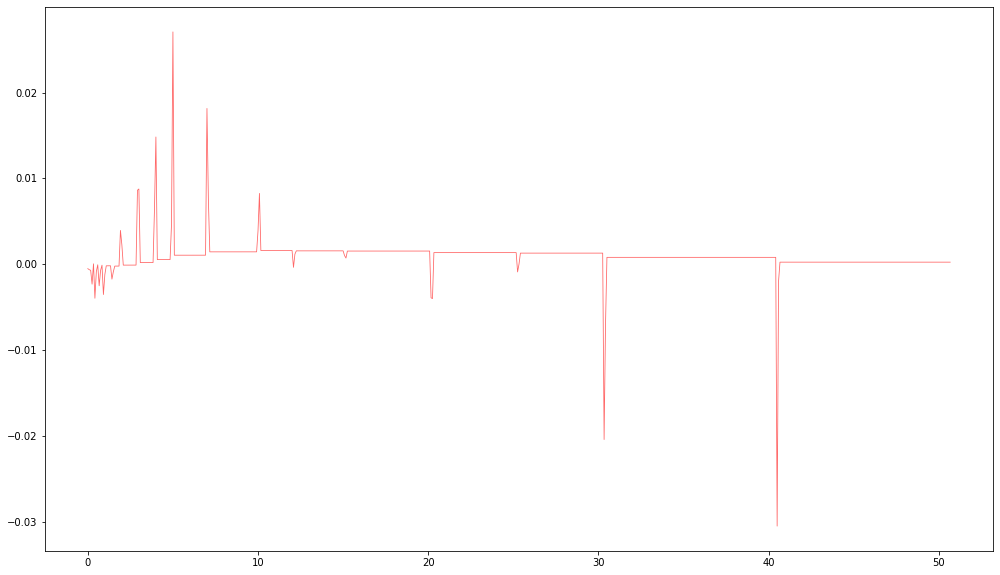

In [7]:
HW.graficar_theta()

In [8]:
HW.creacion_simulacion()

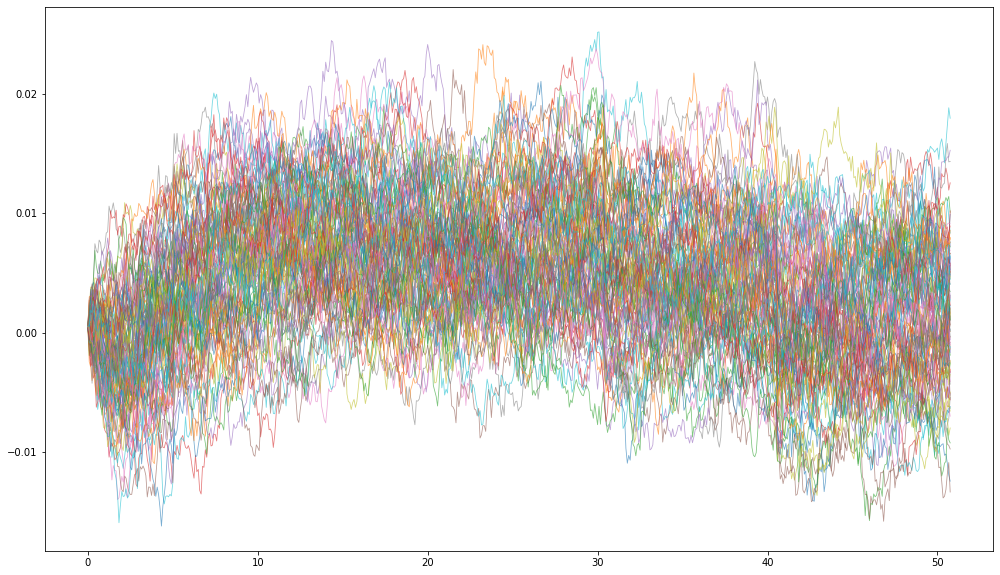

In [9]:
HW.graficar_simulaciones()

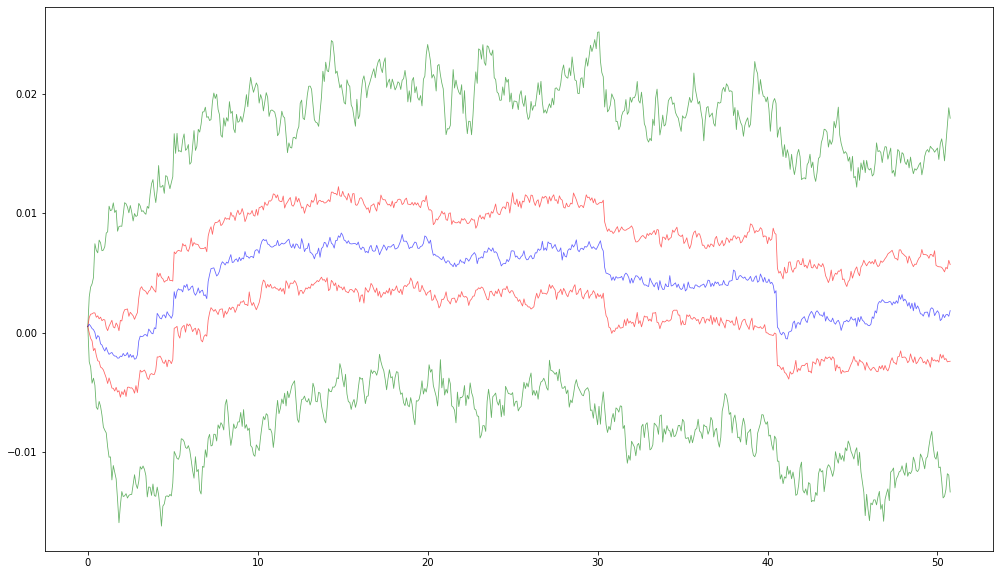

In [10]:
HW.graficar_percentiles_simu()

In [11]:
HW.crear_matriz_A_B()

In [12]:
HW.curva_descuento_media()

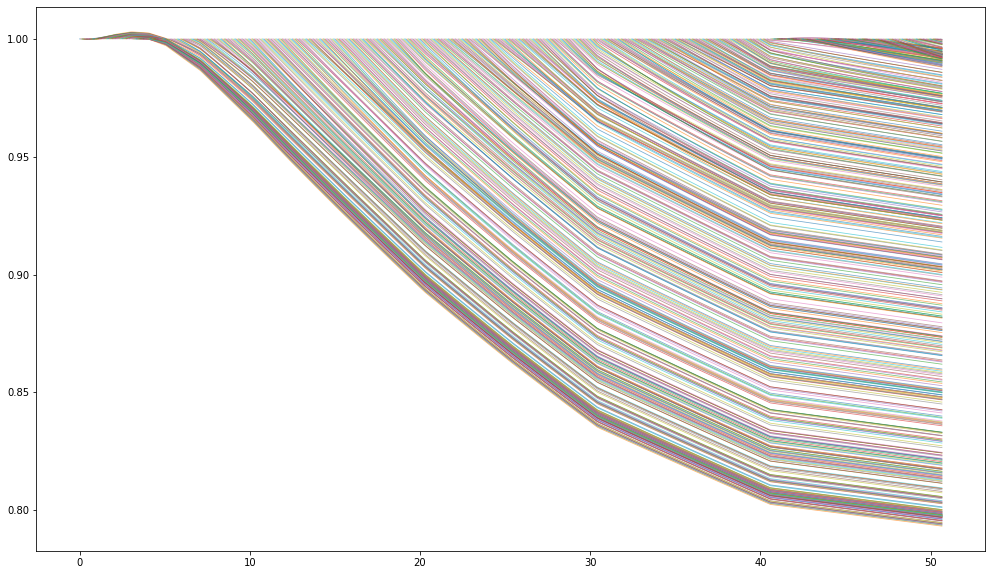

In [13]:
HW.graficar_curvas_descuento_media()

In [14]:
HW.curva_descuentos_aproximada()

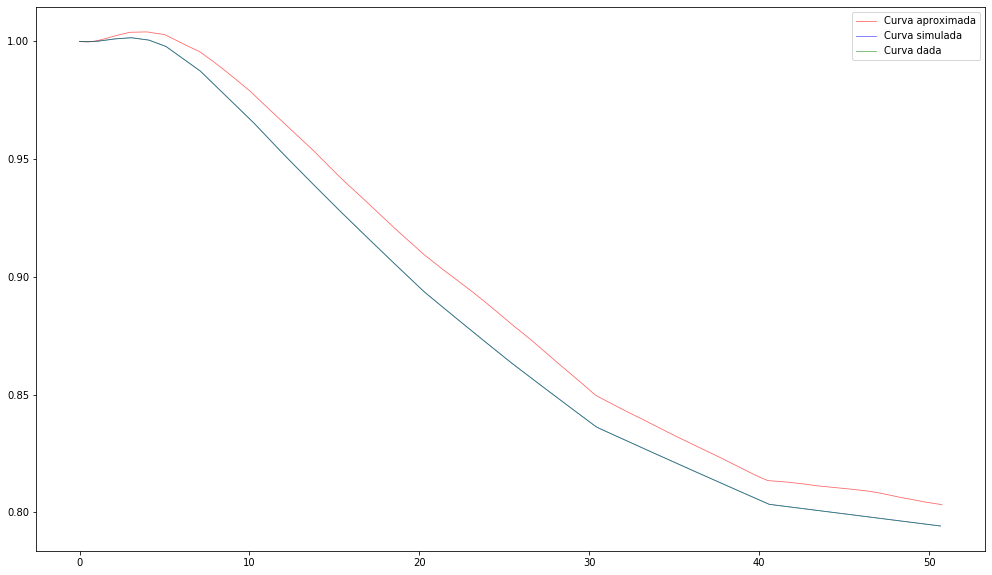

In [15]:
HW.graficar_curvas_descuento_aproximada()

In [16]:
HW.calcular_error()

0.011381092703500633

In [17]:
def calibrar_HW():
    sigma = 0.0036
    curve = curves["ois"]
    r0 = 0.050012/100
    nro_simu = 30
    A = min(1, 100*sigma)
    n_particiones = 20
    da = A/n_particiones
    a = [da]
    errores = []
    for i in range(n_particiones):
        start = time.time()
        HW = HullWhite(a[i], sigma, curve, r0, nro_simu)
        HW.creacion_theta()
        HW.creacion_simulacion()
        HW.crear_matriz_A_B()
        HW.curva_descuento_media()
        HW.curva_descuentos_aproximada()
        errores.append(HW.calcular_error())
        a.append(a[i] + da)
        end = time.time()
        print("Iteracion: ", i+1)
        print("Tiempo: ", end-start)
    a = a[0:len(a)-1]
    return [a, errores]

In [18]:
output = calibrar_HW()

Iteracion:  1
Tiempo:  1.9890294075012207
Iteracion:  2
Tiempo:  4.509904146194458
Iteracion:  3
Tiempo:  2.8721134662628174
Iteracion:  4
Tiempo:  3.902125120162964
Iteracion:  5
Tiempo:  6.434788227081299
Iteracion:  6
Tiempo:  3.2161824703216553
Iteracion:  7
Tiempo:  5.969783782958984
Iteracion:  8
Tiempo:  3.3221826553344727
Iteracion:  9
Tiempo:  4.381845474243164
Iteracion:  10
Tiempo:  3.0361814498901367
Iteracion:  11
Tiempo:  4.585240840911865
Iteracion:  12
Tiempo:  2.8655686378479004
Iteracion:  13
Tiempo:  3.193113327026367
Iteracion:  14
Tiempo:  4.117890357971191
Iteracion:  15
Tiempo:  3.283027172088623
Iteracion:  16
Tiempo:  3.518714666366577
Iteracion:  17
Tiempo:  4.00455379486084
Iteracion:  18
Tiempo:  3.582761287689209
Iteracion:  19
Tiempo:  2.9430999755859375
Iteracion:  20
Tiempo:  4.319331407546997


In [19]:
def calibracion_output(output):
    eje_a = output[0]
    errores = output[1]
    l = 10*(np.mean(a)/np.mean(errores))
    nuevos_errores = []
    for i in range(len(eje_a)):
        nuevos_errores.append(eje_a[i] + errores[i]*l)
    return [eje_a, nuevos_errores]

In [20]:
nuevo_output = calibracion_output(output)

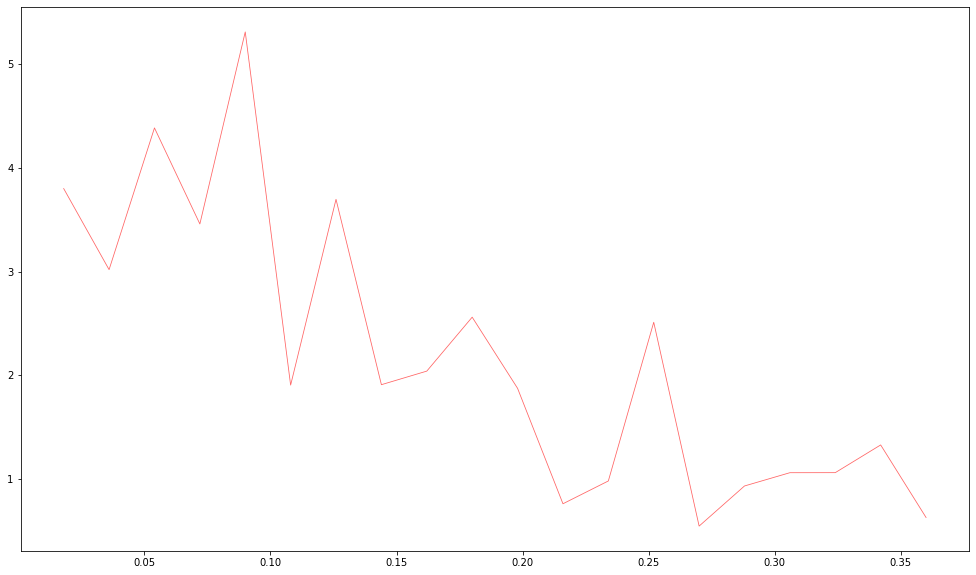

In [21]:
fig, ax = plt.subplots(figsize=(17,10))

ax.plot(nuevo_output[0], nuevo_output[1], lw = 0.8, alpha = 0.6, color = "red")  

In [22]:
print("El minimo es: ", min(nuevo_output[1]))

El minimo es:  0.5483629408454508


In [23]:
a_opt = nuevo_output[0][nuevo_output[1].index(min(nuevo_output[1]))]

In [24]:
print("A opt: ", a_opt)

A opt:  0.26999999999999996


In [25]:
a = a_opt
sigma = 0.0036
curve = curves["ois"]
r0 = 0.050012/100
nro_simu = 100

HW = HullWhite(a, sigma, curve, r0, nro_simu)

In [26]:
HW.creacion_theta()

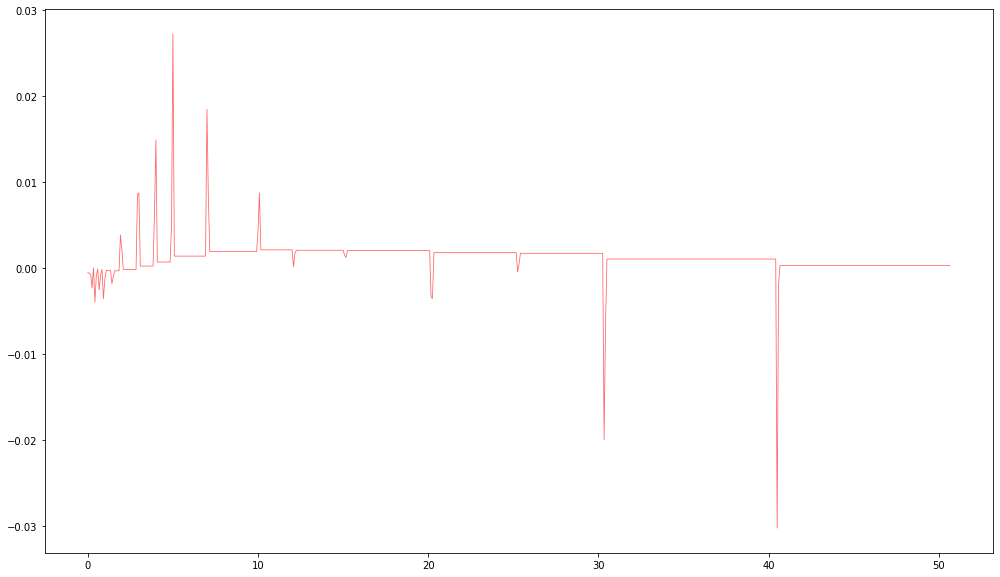

In [27]:
HW.graficar_theta()

In [28]:
HW.creacion_simulacion()

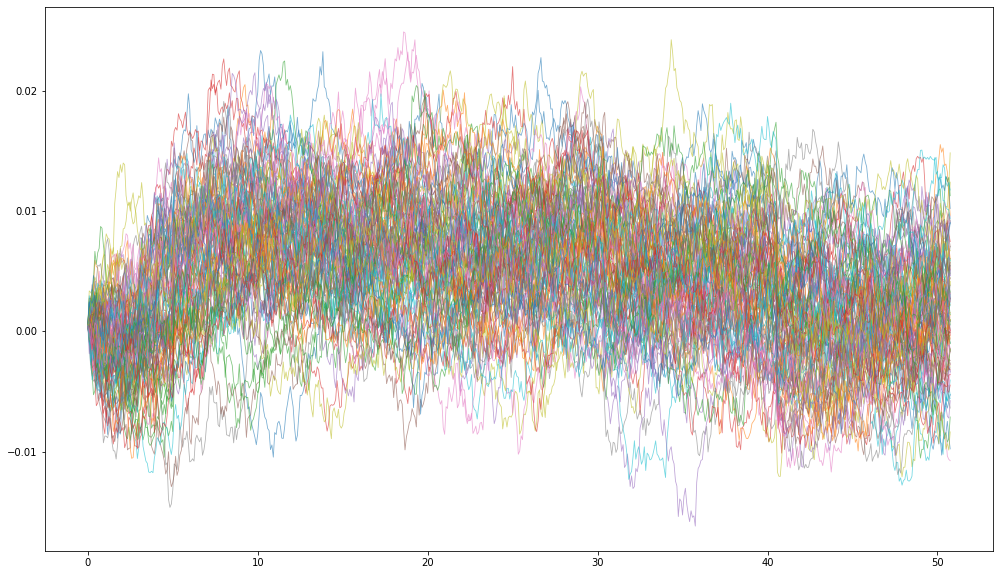

In [29]:
HW.graficar_simulaciones()

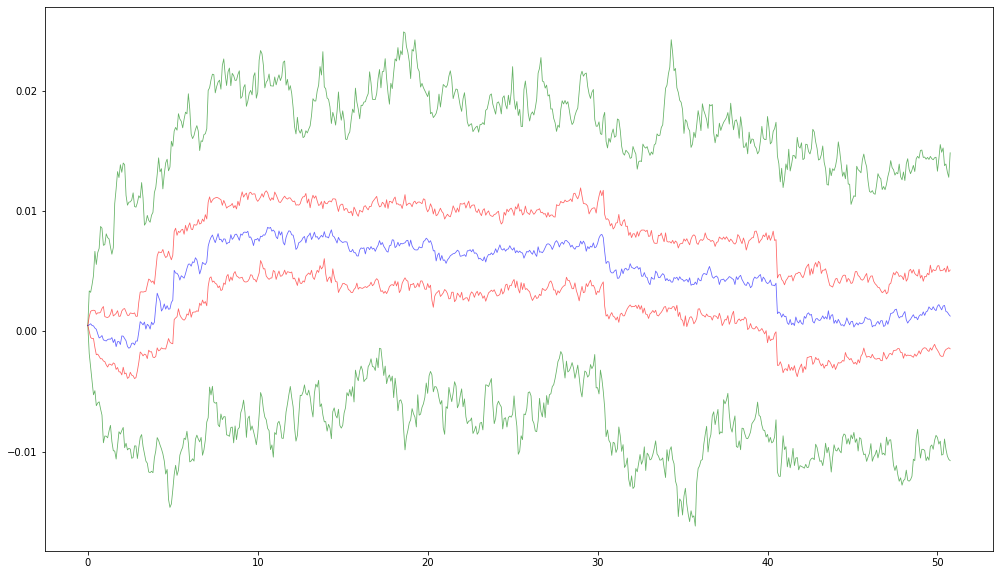

In [30]:
HW.graficar_percentiles_simu()

In [31]:
HW.crear_matriz_A_B()

In [32]:
start = time.time()

HW.curvas_descuento()

end = time.time()

print("Tiempo: ", end-start)

Tiempo:  42.82944941520691


In [33]:
HW.curva_descuento_media()

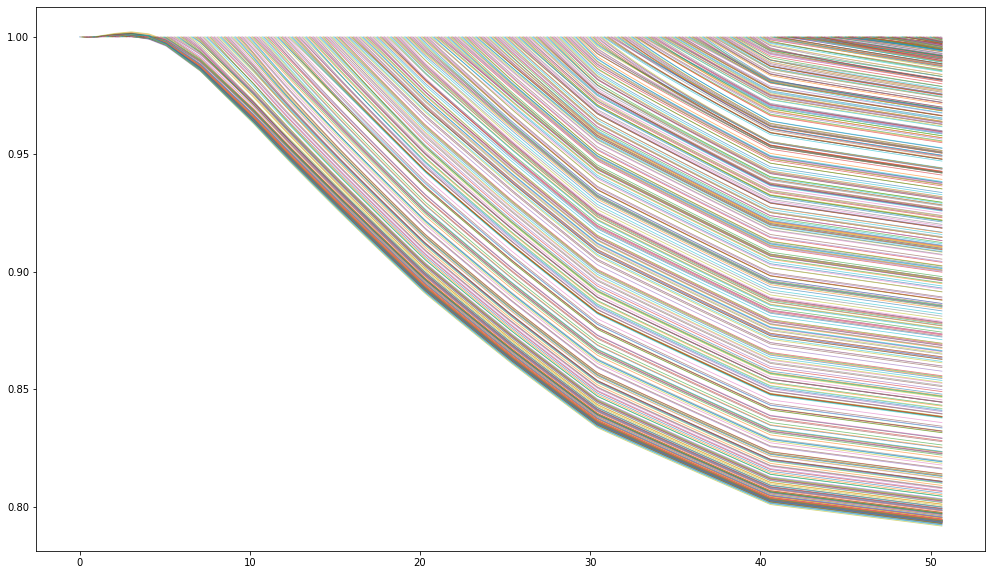

In [34]:
HW.graficar_curvas_descuento_media()

In [35]:
HW.curva_descuentos_aproximada()

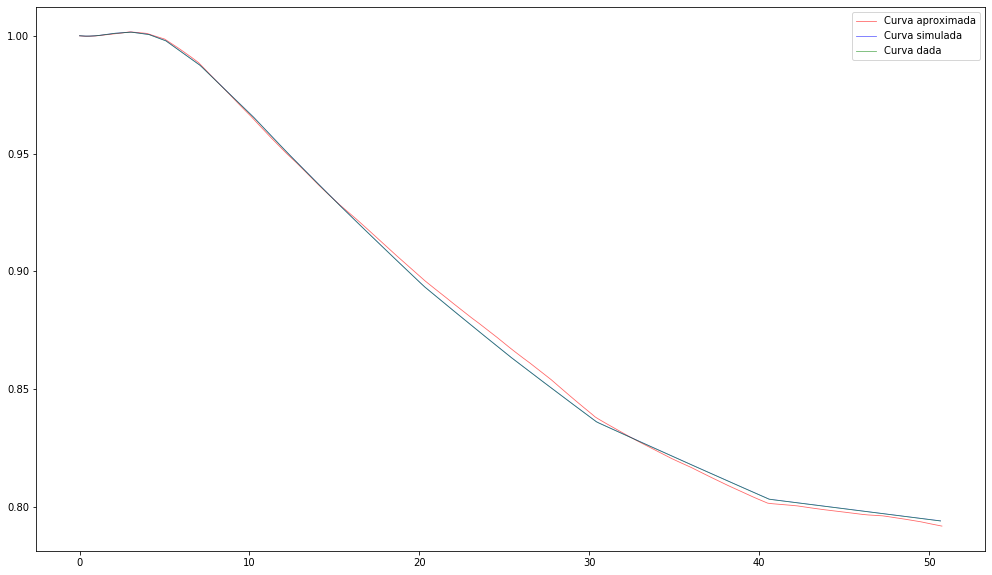

In [36]:
HW.graficar_curvas_descuento_aproximada()

In [37]:
HW.calcular_error()

0.0014275392725755884

In [38]:
curvas_descuento_utilizar = HW.curvas_descuento_todas

In [39]:
class JYModel:
    
    def __init__(self, a_n, a_r, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, 
                 numero_simulaciones, n_0, r_0, i_0):
        
        self.a_n = a_n
        self.a_r = a_r
        self.sigma_n = sigma_n
        self.sigma_r = sigma_r
        self.sigma_i = sigma_i
        self.corr_n_r = corr_n_r
        self.corr_r_i = corr_r_i
        self.corr_i_n = corr_i_n
        self.n_0 = n_0
        self.r_0 = r_0
        self.i_0 = i_0
        self.curves = curves
        self.dt = 1/12
        self.T = min(self.curves['coll_usd_uf'][1], self.curves["coll_usd_clp"][1])
        self.nro_periodos = int(self.T/self.dt) + 1
        self.nro_simu = numero_simulaciones
        self.curva_n = self.curves["coll_usd_clp"][0]
        self.curva_r = self.curves["coll_usd_uf"][0]
        self.t_lim = (self.nro_periodos-1)*self.dt
        self.epsilon = self.dt
    
    def funcion_M_n(self, T):
        if T >= self.t_lim:
            valor = -(math.log(self.curva_n.discount(T)) - math.log(self.curva_n.discount(T-self.epsilon)))/(self.epsilon)
        else:
            valor = -(math.log(self.curva_n.discount(T + self.epsilon)) - math.log(self.curva_n.discount(T)))/(self.epsilon)
        return valor
    
    def derivada_funcion_M_n(self, T):
        if T >= self.t_lim:
            valor = (self.funcion_M_n(T) - self.funcion_M_n(T - self.epsilon))/(self.epsilon)
        else:
            valor = (self.funcion_M_n(T + self.epsilon) - self.funcion_M_n(T))/(self.epsilon)
        return valor
    
    def theta_n_t(self, t):
        parte_1 = self.derivada_funcion_M_n(t) + self.a_n*self.funcion_M_n(t)
        parte_2 = ((self.sigma_n**2)/(2*self.a_n))*(1-math.exp(-2*self.a_n*t))
        valor = parte_1 + parte_2
        return valor
    
    def creacion_theta_n(self):
        self.tiempos = []
        for i in range(self.nro_periodos):
            self.tiempos.append(i*self.dt)
        self.theta_n = []
        for t in self.tiempos:
            self.theta_n.append(self.theta_n_t(t))
    
    def graficar_theta_n(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos, self.theta_n, lw = 0.8, alpha = 0.6)
    
    def funcion_M_r(self, T):
        if T >= self.t_lim:
            valor = -(math.log(self.curva_r.discount(T)) - math.log(self.curva_r.discount(T-self.epsilon)))/(self.epsilon)
        else:
            valor = -(math.log(self.curva_r.discount(T+self.epsilon)) - math.log(self.curva_r.discount(T)))/(self.epsilon)
        return valor
    
    def derivada_funcion_M_r(self, T):
        if T >= self.t_lim:
            valor = (self.funcion_M_r(T) - self.funcion_M_r(T - self.epsilon))/(self.epsilon)
        else:
            valor = (self.funcion_M_r(T + self.epsilon) - self.funcion_M_r(T))/(self.epsilon)
        return valor
    
    def theta_r_t(self, t):
        parte_1 = self.derivada_funcion_M_r(t) + self.a_r*self.funcion_M_r(t)
        parte_2 = ((self.sigma_r**2)/(2*self.a_r))*(1-math.exp(-2*self.a_r*t))
        valor = parte_1 + parte_2
        return valor
    
    def creacion_theta_r(self):
        self.tiempos = []
        for i in range(self.nro_periodos):
            self.tiempos.append(i*self.dt)
        self.theta_r = []
        for t in self.tiempos:
            self.theta_r.append(self.theta_r_t(t))
    
    def graficar_theta_r(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos, self.theta_r, lw = 0.8, alpha = 0.6)
    
    
    def calcular_simulaciones(self):
        
        self.n_total = []
        self.r_total = []
        self.i_total = []
        
        cov_n = self.sigma_n**2
        cov_r = self.sigma_r**2
        cov_i = self.sigma_i**2
        cov_n_r = self.corr_n_r*self.sigma_n*self.sigma_r
        cov_r_i = self.corr_r_i*self.sigma_r*self.sigma_i
        cov_i_n = self.corr_i_n*self.sigma_n*self.sigma_i
        cov_matrix = np.matrix([[cov_n, cov_n_r, cov_i_n], [cov_n_r, cov_r, cov_r_i], [cov_i_n, cov_r_i, cov_i]])
        for i in range(self.nro_simu): 
            n_sim = [self.n_0]
            r_sim = [self.r_0]
            i_sim = [self.i_0]
            for t in range(self.nro_periodos):
                dW = stats.multivariate_normal(mean=[0,0,0], cov=cov_matrix)
                dW_random = dW.rvs(size = 1)
                n_sim.append(n_sim[t] + (self.theta_n[t]-self.a_n*n_sim[t])*self.dt + dW_random[0]*math.sqrt(self.dt))
                r_sim.append(r_sim[t] + (self.theta_r[t]-cov_r_i-self.a_r*r_sim[t])*self.dt + dW_random[1]*math.sqrt(self.dt))
                i_sim.append(i_sim[t] + i_sim[t]*(n_sim[t] - r_sim[t])*self.dt + i_sim[t]*dW_random[2]*math.sqrt(self.dt))
            self.n_total.append(n_sim)
            self.r_total.append(r_sim)
            self.i_total.append(i_sim)
    
    def graficar_n(self):
        self.tiempos_n = []
        for t in range(len(self.n_total[0])):
            self.tiempos_n.append(t*self.dt)
        fig, ax = plt.subplots(figsize=(17,10))
        for i in range(self.nro_simu):
            ax.plot(self.tiempos_n, self.n_total[i], lw = 0.8, alpha = 0.6)
    
    def graficar_r(self):
        self.tiempos_r = []
        for t in range(len(self.r_total[0])):
            self.tiempos_r.append(t*self.dt)
        fig, ax = plt.subplots(figsize=(17,10))
        for i in range(self.nro_simu):
            ax.plot(self.tiempos_r, self.r_total[i], lw = 0.8, alpha = 0.6)
    
    def graficar_i(self):
        self.tiempos_i = []
        for t in range(len(self.i_total[0])):
            self.tiempos_i.append(t*self.dt)           
        fig, ax = plt.subplots(figsize=(17,10))
        for i in range(self.nro_simu):
            ax.plot(self.tiempos_i, self.i_total[i], lw = 0.8, alpha = 0.6)
    
    def graficar_percentiles_i(self):
        self.i_max = []
        self.i_min = []
        self.i_75 = []
        self.i_25 = []
        self.i_50 = []
        for t in range(self.nro_periodos+1):
            lista = []
            for i in range(self.nro_simu):
                lista.append(self.i_total[i][t])
            self.i_min.append(min(lista))
            self.i_max.append(max(lista))
            self.i_50.append(np.percentile(lista, 50))
            self.i_75.append(np.percentile(lista, 75))
            self.i_25.append(np.percentile(lista, 25))
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos_i, self.i_max, lw = 0.8, alpha = 0.6, color = "green")
        ax.plot(self.tiempos_i, self.i_min, lw = 0.8, alpha = 0.6, color = "green")
        ax.plot(self.tiempos_i, self.i_75, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.tiempos_i, self.i_25, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.tiempos_i, self.i_50, lw = 0.8, alpha = 0.6, color = "blue")
    
    def graficar_intervalo_especifico(self, porcentaje):
        self.i_sup = []
        self.i_inf = []
        self.i_50 = []
        for t in range(self.nro_periodos+1):
            lista = []
            for i in range(self.nro_simu):
                lista.append(self.i_total[i][t])
            self.i_50.append(np.percentile(lista, 50))
            self.i_sup.append(np.percentile(lista, 50 + porcentaje/2))
            self.i_inf.append(np.percentile(lista, 50 - porcentaje/2))
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos_i, self.i_sup, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.tiempos_i, self.i_inf, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.tiempos_i, self.i_50, lw = 0.8, alpha = 0.6, color = "blue")
        
    def curva_descuentos_aproximada_n(self):
        curvas_totales = []
        for i in range(len(self.n_total)):
            nueva_curva = []
            suma = 0
            for j in range(len(self.n_total[0])):
                suma = suma + self.n_total[i][j]
                nueva_curva.append(math.exp(-suma*self.dt))
            curvas_totales.append(nueva_curva)
        self.curva_d_n = []
        for t in range(len(curvas_totales[0])):
            lista = []
            for p in range(len(curvas_totales)):
                lista.append(curvas_totales[p][t])
            media = np.mean(lista)
            self.curva_d_n.append(media)
    
    def graficar_curva_aproximada_n(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos_n, self.curva_d_n, lw = 0.8, alpha = 0.6, color = "red")
    
    def curva_descuentos_aproximada_r(self):
        curvas_totales = []
        for i in range(len(self.r_total)):
            nueva_curva = []
            suma = 0
            for j in range(len(self.r_total[0])):
                suma = suma + self.r_total[i][j]
                nueva_curva.append(math.exp(-suma*self.dt))
            curvas_totales.append(nueva_curva)
        self.curva_d_r = []
        for t in range(len(curvas_totales[0])):
            lista = []
            for p in range(len(curvas_totales)):
                lista.append(curvas_totales[p][t])
            media = np.mean(lista)
            self.curva_d_r.append(media)
    
    def graficar_curva_aproximada_r(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos_r, self.curva_d_r, lw = 0.8, alpha = 0.6, color = "red")
        
    def B_n(self, t, T):
        valor = (1/self.a_n)*(1-math.exp(-self.a_n*(T-t)))
        return valor
    
    def A_n(self, t, T):
        fraccion = (self.curva_n.discount(T)/self.curva_n.discount(t))
        exponente = self.B_n(t,T)*self.funcion_M_n(t)-((self.sigma_n**2)/(4*self.a_n))*(1-math.exp(-2*self.a_n*t))*(self.B_n(t,T)**2)
        valor = fraccion*math.exp(exponente)
        return valor
    
    def creacion_matriz_A_B_n(self):     
        self.matriz_A_n = []
        self.matriz_B_n = []
        for i in range(self.nro_periodos):
            fila_A = []
            fila_B = []
            for j in range(self.nro_periodos):
                if i <= j:
                    t = i*self.dt
                    T = j*self.dt
                    fila_A.append(self.A_n(t,T))
                    fila_B.append(self.B_n(t,T))
                else:
                    fila_A.append(0)
                    fila_B.append(0)     
            self.matriz_A_n.append(fila_A)
            self.matriz_B_n.append(fila_B)
    
    def B_r(self, t, T):
        valor = (1/self.a_r)*(1-math.exp(-self.a_r*(T-t)))
        return valor
    
    def A_r(self, t, T):
        fraccion = (self.curva_r.discount(T)/self.curva_r.discount(t))
        exponente = self.B_r(t,T)*self.funcion_M_r(t)-((self.sigma_r**2)/(4*self.a_r))*(1-math.exp(-2*self.a_r*t))*(self.B_r(t,T)**2)
        valor = fraccion*math.exp(exponente)
        return valor
    
    def creacion_matriz_A_B_r(self):     
        self.matriz_A_r = []
        self.matriz_B_r = []
        for i in range(self.nro_periodos):
            fila_A = []
            fila_B = []
            for j in range(self.nro_periodos):
                if i <= j:
                    t = i*self.dt
                    T = j*self.dt
                    fila_A.append(self.A_r(t,T))
                    fila_B.append(self.B_r(t,T))
                else:
                    fila_A.append(0)
                    fila_B.append(0)     
            self.matriz_A_r.append(fila_A)
            self.matriz_B_r.append(fila_B)
    
    def curvas_descuentos_n_r(self):
        self.curvas_descuento_n = []
        for i in range(len(self.n_total)):
            curvas_simulacion_n = []
            for j in range(len(self.n_total[0])-1):
                curva_n = []
                for k in range(j, len(self.n_total[0]) - 1):
                    curva_n.append(self.matriz_A_n[j][k]*math.exp(-self.matriz_B_n[j][k]*self.n_total[i][j]))
                curvas_simulacion_n.append(curva_n)
            self.curvas_descuento_n.append(curvas_simulacion_n)
        self.curvas_descuento_r = []
        for i in range(len(self.r_total)):
            curvas_simulacion_r = []
            for j in range(len(self.r_total[0]) - 1):
                curva_r = []
                for k in range(j, len(self.r_total[0]) - 1):
                    curva_r.append(self.matriz_A_r[j][k]*math.exp(-self.matriz_B_r[j][k]*self.r_total[i][j]))
                curvas_simulacion_r.append(curva_r)
            self.curvas_descuento_r.append(curvas_simulacion_r)
            
    def calcular_curva_media_n(self):
        self.path_media_n = []
        for i in range(len(self.n_total[0])):
            lista = []
            for j in range(len(self.n_total)):
                lista.append(self.n_total[j][i])
            self.path_media_n.append(np.percentile(lista, 50))
    
    def curva_descuento_media_n(self):
        self.curva_media_n = []
        for i in range(self.nro_periodos):
            curva = []
            for j in range(i, self.nro_periodos):
                curva.append(self.matriz_A_n[i][j]*math.exp(-self.matriz_B_n[i][j]*self.path_media_n[i]))
            self.curva_media_n.append(curva)
    
    def curva_real_n(self):
        self.real_curva_n = []
        for i in range(len(self.curva_media_n[0])):
            self.real_curva_n.append(self.curva_n.discount(i*self.dt))
            
    def graficar_comparacion_curvas_n(self):
        self.tiempos_n_1 = []
        self.tiempos_n_2 = []
        for i in range(len(self.curva_media_n[0])):
            self.tiempos_n_1.append(i*self.dt)
            self.tiempos_n_2.append(i*self.dt)
        self.tiempos_n_2.append((i+1)*self.dt)
        fig, ax = plt.subplots(figsize=(17,10))
        grafico_1, = ax.plot(self.tiempos_n_1, self.curva_media_n[0], lw = 0.8, alpha = 0.6, color = "blue")
        grafico_2, = ax.plot(self.tiempos_n_2, self.curva_d_n, lw = 0.8, alpha = 0.6, color = "red")
        grafico_3, = ax.plot(self.tiempos_n_1, self.real_curva_n, lw = 0.8, alpha = 0.6, color = "green")
        grafico_1.set_label("Curva Simulada")
        grafico_2.set_label("Curva Aproximada")
        grafico_3.set_label("Curva Real")
        ax.legend()
    
    def calcular_curva_media_r(self):
        self.path_media_r = []
        for i in range(len(self.r_total[0])):
            lista = []
            for j in range(len(self.r_total)):
                lista.append(self.r_total[j][i])
            self.path_media_r.append(np.percentile(lista, 50))
    
    def curva_descuento_media_r(self):
        self.curva_media_r = []
        for i in range(self.nro_periodos):
            curva = []
            for j in range(i, self.nro_periodos):
                curva.append(self.matriz_A_r[i][j]*math.exp(-self.matriz_B_r[i][j]*self.path_media_r[i]))
            self.curva_media_r.append(curva)
    
    def curva_real_r(self):
        self.real_curva_r = []
        for i in range(len(self.curva_media_r[0])):
            self.real_curva_r.append(self.curva_r.discount(i*self.dt))
            
    def graficar_comparacion_curvas_r(self):
        self.tiempos_r_1 = []
        self.tiempos_r_2 = []
        for i in range(len(self.curva_media_r[0])):
            self.tiempos_r_1.append(i*self.dt)
            self.tiempos_r_2.append(i*self.dt)
        self.tiempos_r_2.append((i+1)*self.dt)
        fig, ax = plt.subplots(figsize=(17,10))
        grafico_1, = ax.plot(self.tiempos_r_1, self.curva_media_r[0], lw = 0.8, alpha = 0.6, color = "blue")
        grafico_2, = ax.plot(self.tiempos_r_2, self.curva_d_r, lw = 0.8, alpha = 0.6, color = "red")
        grafico_3, = ax.plot(self.tiempos_r_1, self.real_curva_r, lw = 0.8, alpha = 0.6, color = "green")
        grafico_1.set_label("Curva Simulada")
        grafico_2.set_label("Curva Aproximada")
        grafico_3.set_label("Curva Real")
        ax.legend()
        
    def calcular_error_r(self):
        self.tiempos_r_1 = []
        self.tiempos_r_2 = []
        for i in range(len(self.curva_media_r[0])):
            self.tiempos_r_1.append(i*self.dt)
            self.tiempos_r_2.append(i*self.dt)
        self.tiempos_r_2.append((i+1)*self.dt)
        error = 0
        for i in range(len(self.tiempos_r_1)):
            error = error + abs(self.curva_media_r[0][i] - self.curva_d_r[i])
        error = error/len(self.tiempos_r_1)
        return error
    
    def calcular_error_n(self):
        self.tiempos_n_1 = []
        self.tiempos_n_2 = []
        for i in range(len(self.curva_media_n[0])):
            self.tiempos_n_1.append(i*self.dt)
            self.tiempos_n_2.append(i*self.dt)
        self.tiempos_n_2.append((i+1)*self.dt)
        error = 0
        for i in range(len(self.tiempos_n_1)):
            error = error + abs(self.curva_media_n[0][i] - self.curva_d_n[i])
        error = error/len(self.tiempos_n_1)
        return error

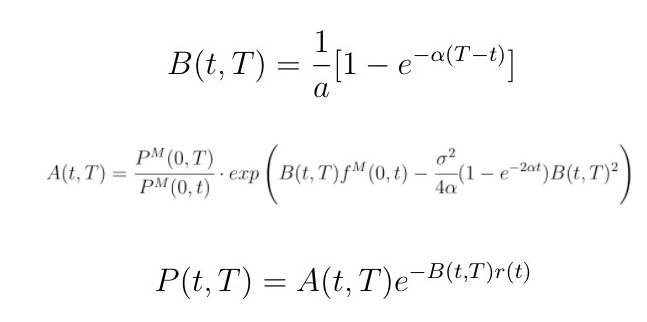

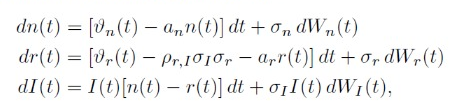

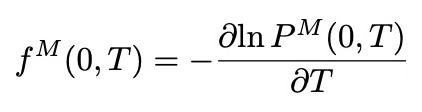

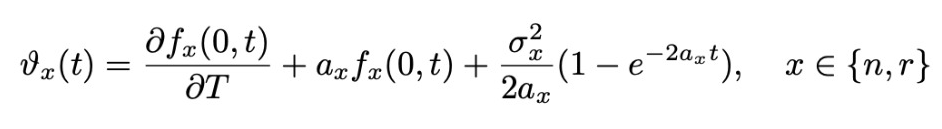

In [40]:
a_n = 10**(-6)
a_r = 10**(-6)
sigma_n = 0.011306
sigma_r = 0.010816
sigma_i = 0.0625627  
corr_n_r = 0.420879649       
corr_r_i = 0.089190964  
corr_i_n = 0.006508171      
n_0 = 0.005
r_0 = 0.005
i_0 = 28000
dt = 0.08333333333333
numero_simulaciones = 100

JY = JYModel(a_n, a_r, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, 
                 numero_simulaciones, n_0, r_0, i_0)

In [41]:
JY.creacion_theta_n()

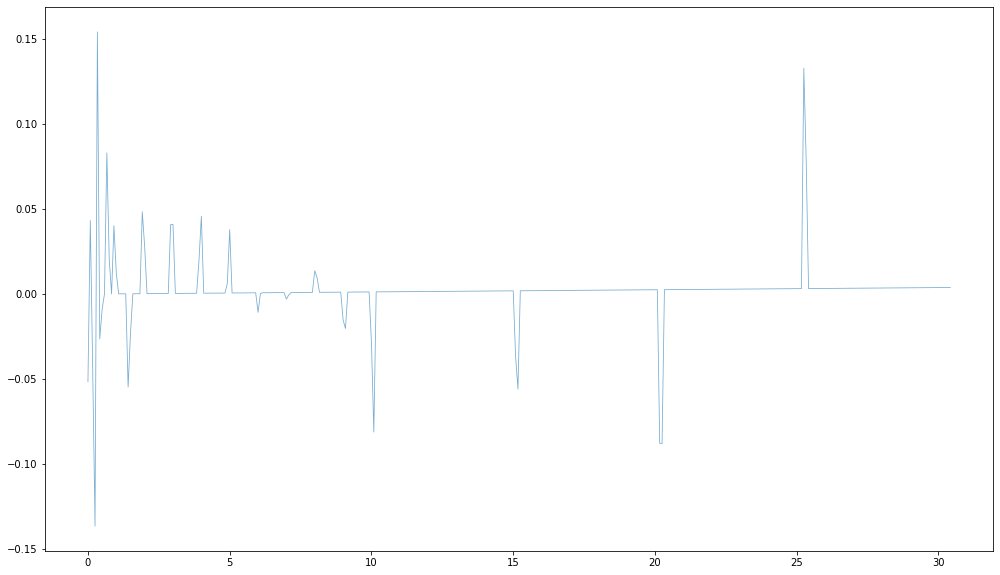

In [42]:
JY.graficar_theta_n()

In [43]:
JY.creacion_theta_r()

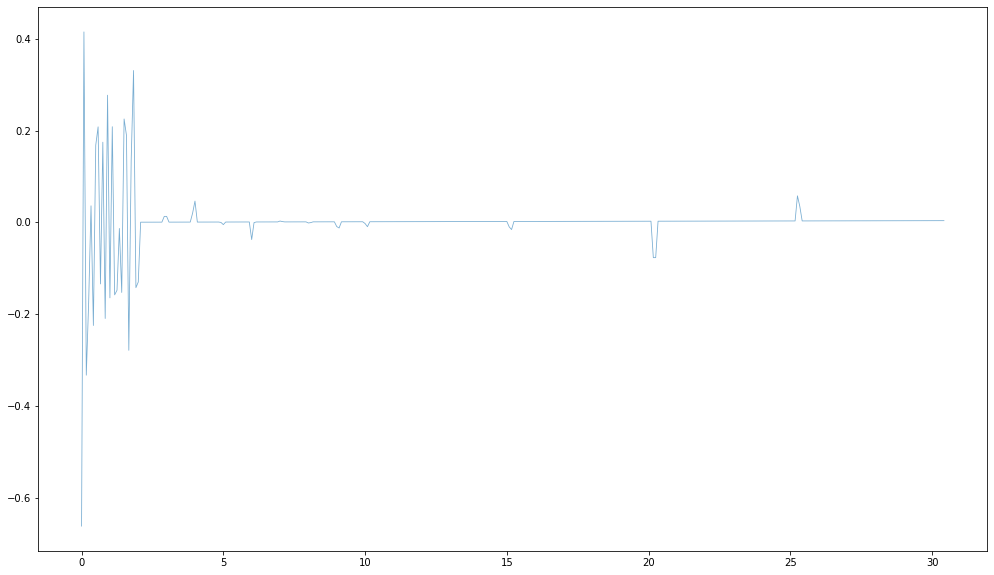

In [44]:
JY.graficar_theta_r()

In [45]:
JY.calcular_simulaciones()

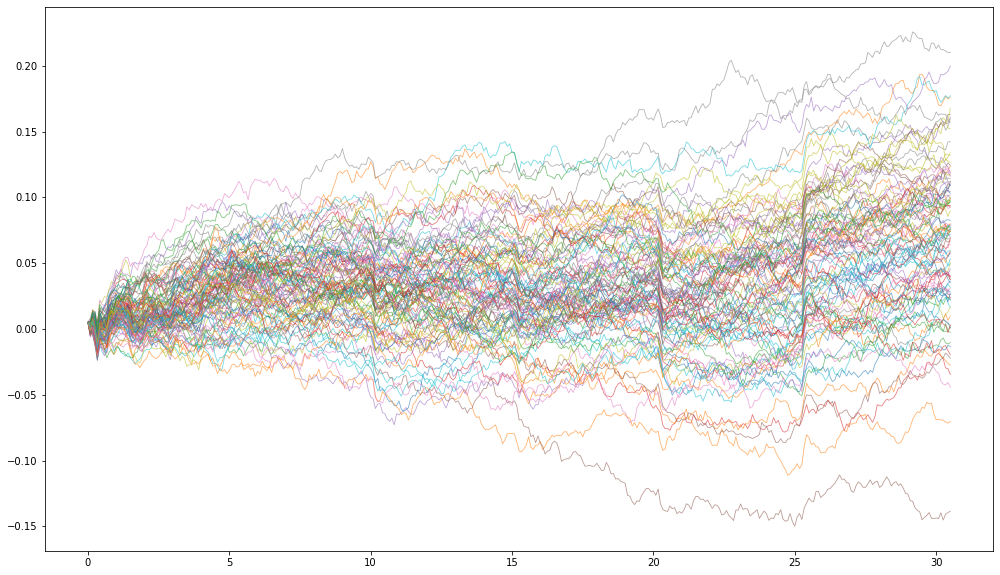

In [46]:
JY.graficar_n()

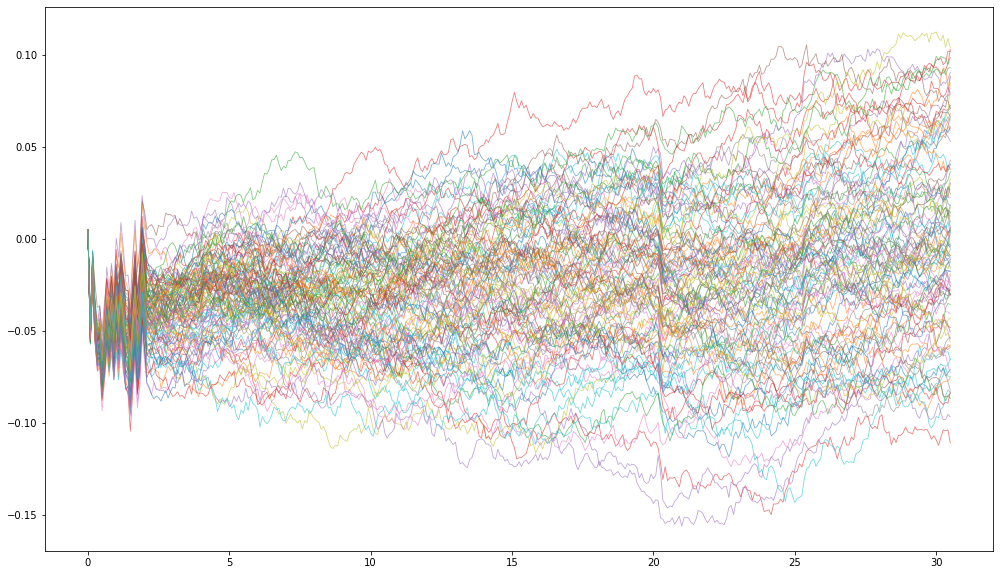

In [47]:
JY.graficar_r()

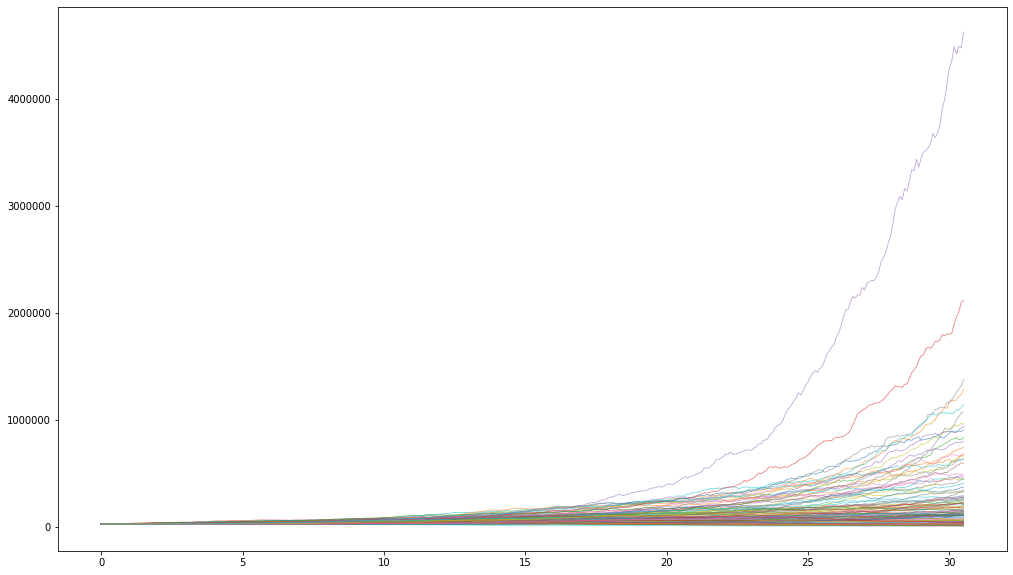

In [48]:
JY.graficar_i()

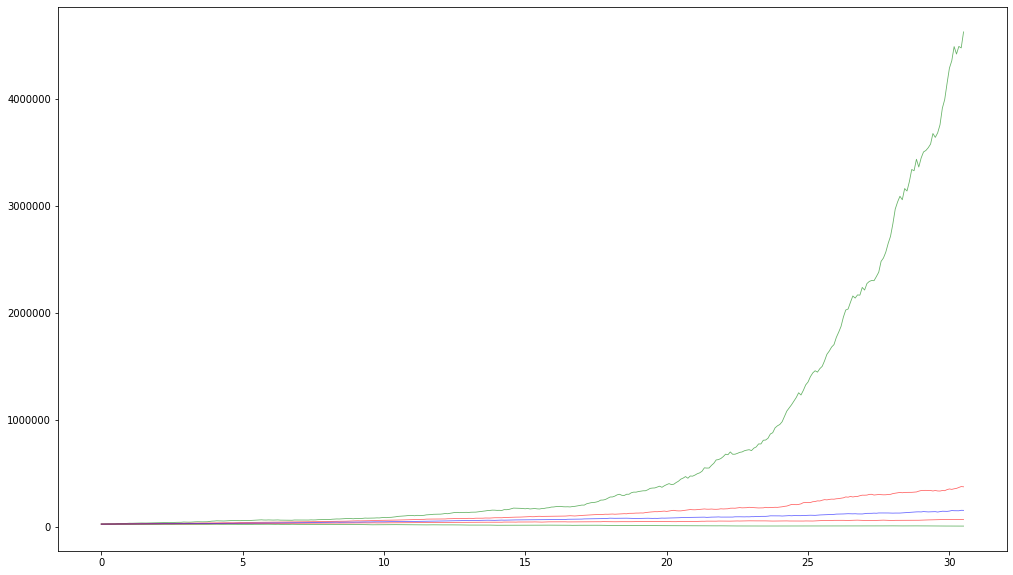

In [49]:
JY.graficar_percentiles_i()

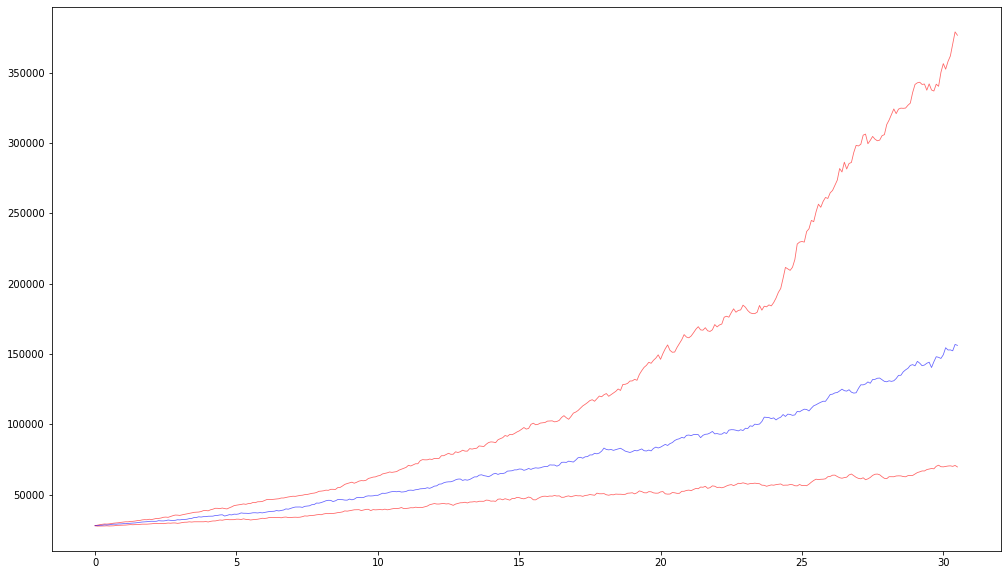

In [50]:
JY.graficar_intervalo_especifico(50)

In [51]:
JY.curva_descuentos_aproximada_n()

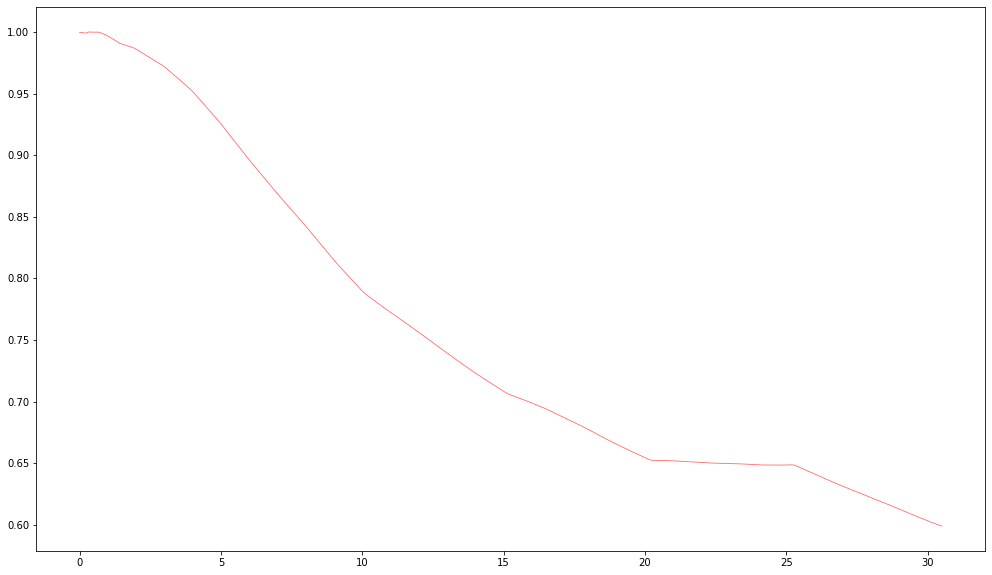

In [52]:
JY.graficar_curva_aproximada_n()

In [53]:
JY.curva_descuentos_aproximada_r()

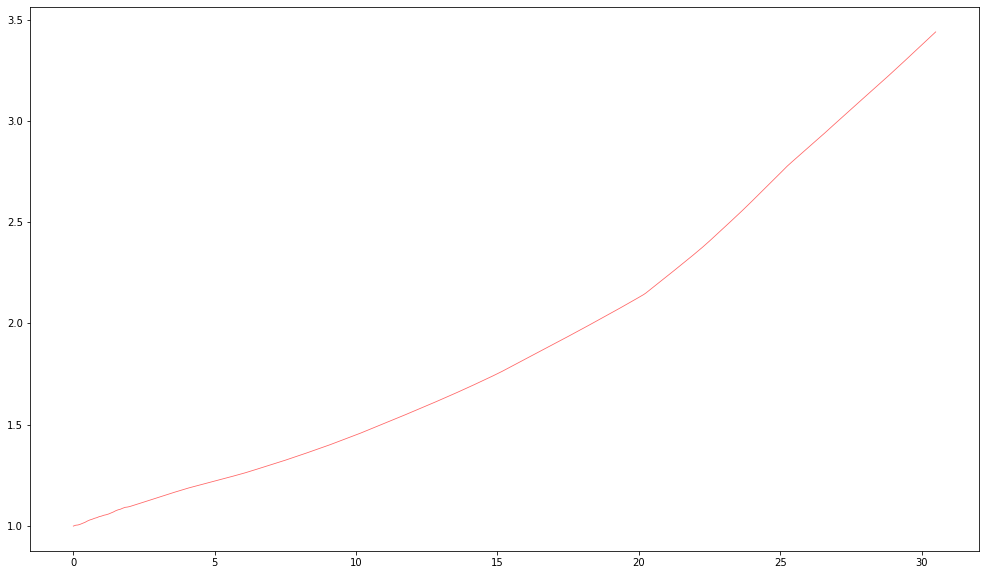

In [54]:
JY.graficar_curva_aproximada_r()

In [55]:
JY.creacion_matriz_A_B_n()

In [56]:
JY.creacion_matriz_A_B_r()

In [57]:
JY.curvas_descuentos_n_r()

In [58]:
JY.calcular_curva_media_n()

In [59]:
JY.curva_descuento_media_n()

In [60]:
JY.curva_real_n()

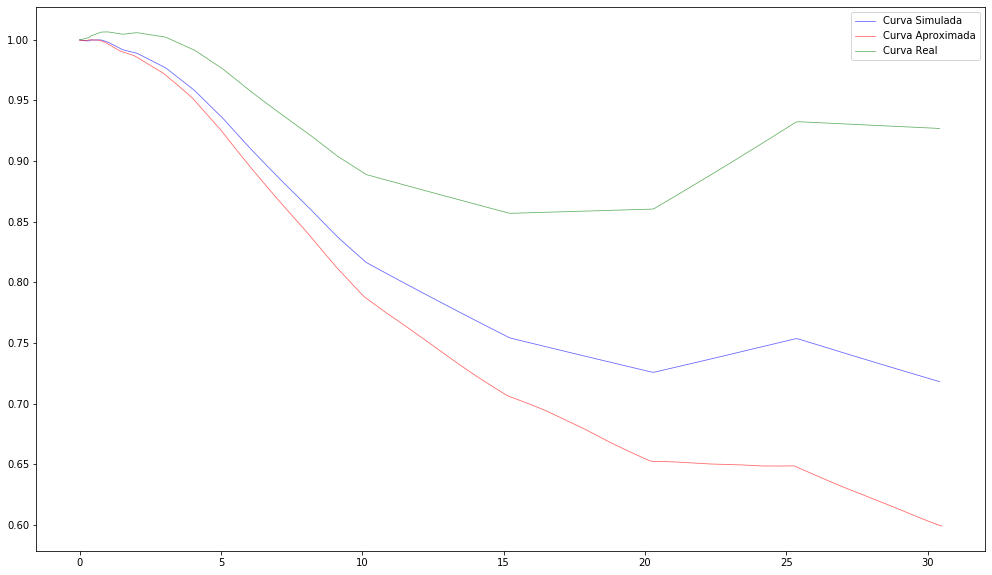

In [61]:
JY.graficar_comparacion_curvas_n()

In [62]:
#--------------------

In [63]:
JY.calcular_curva_media_r()

In [64]:
JY.curva_descuento_media_r()

In [65]:
JY.curva_descuento_media_r()

In [66]:
JY.curva_real_r()

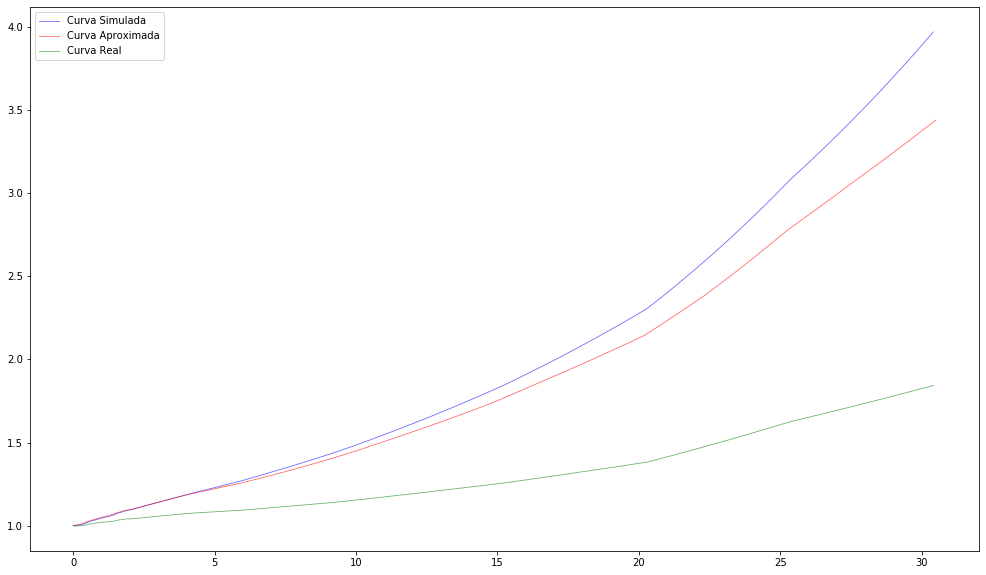

In [67]:
JY.graficar_comparacion_curvas_r()

In [68]:
JY.calcular_error_r()

0.13530243837823253

In [69]:
JY.calcular_error_n()

0.054589497710033935

In [70]:
def calibrar_a_r(n_particiones):
    A_r = min(100*sigma_r, 1)
    da = A_r/n_particiones
    
    eje_a_r = [da]
    error_r = []
    
    for i in range(n_particiones):
        
        start = time.time()
        
        JY = JYModel(0.2, eje_a_r[i], sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, 
                     numero_simulaciones, n_0, r_0, i_0)
        
        JY.creacion_theta_n()
        JY.creacion_theta_r()
        
        JY.calcular_simulaciones()
        JY.curva_descuentos_aproximada_n()
        JY.curva_descuentos_aproximada_r()
        
        JY.creacion_matriz_A_B_n()
        JY.creacion_matriz_A_B_r()
        
        JY.calcular_curva_media_n()
        JY.curva_descuento_media_n()
        JY.curva_real_n()
        
        JY.calcular_curva_media_r()
        JY.curva_descuento_media_r()
        JY.curva_real_r()
        error_r.append(JY.calcular_error_r())
        
        eje_a_r.append(eje_a_r[i] + da)
        
        end = time.time()
        
        print("Iteracion: ", i+1)
        print("Tiempo: ", end-start)
        
    eje_a_r = eje_a_r[0:len(eje_a_r)-1]
    
    return [eje_a_r, error_r]

In [71]:
n_particiones = 20

output = calibrar_a_r(n_particiones)

Iteracion:  1
Tiempo:  23.978862285614014
Iteracion:  2
Tiempo:  22.215330123901367
Iteracion:  3
Tiempo:  23.848662853240967
Iteracion:  4
Tiempo:  21.773428440093994
Iteracion:  5
Tiempo:  23.06850814819336
Iteracion:  6
Tiempo:  21.269673347473145
Iteracion:  7
Tiempo:  20.60417938232422
Iteracion:  8
Tiempo:  25.091275215148926
Iteracion:  9
Tiempo:  23.10458731651306
Iteracion:  10
Tiempo:  22.671926021575928
Iteracion:  11
Tiempo:  22.337525367736816
Iteracion:  12
Tiempo:  24.369776487350464
Iteracion:  13
Tiempo:  24.06801176071167
Iteracion:  14
Tiempo:  24.624701499938965
Iteracion:  15
Tiempo:  23.872173309326172
Iteracion:  16
Tiempo:  25.57153868675232
Iteracion:  17
Tiempo:  26.863020658493042
Iteracion:  18
Tiempo:  28.985893726348877
Iteracion:  19
Tiempo:  25.363086462020874
Iteracion:  20
Tiempo:  25.869888305664062


In [72]:
def calcular_a_r_optimo(output):
    eje_a_r = output[0]
    errores_r = output[1]
    l = (np.mean(eje_a_r)/np.mean(errores_r))
    
    nuevos_errores_r = []
    
    for i in range(len(errores_r)):
        nuevos_errores_r.append(errores_r[i]*l + eje_a_r[i])
    
    return [eje_a_r, nuevos_errores_r]

In [73]:
nuevo_output = calcular_a_r_optimo(output)

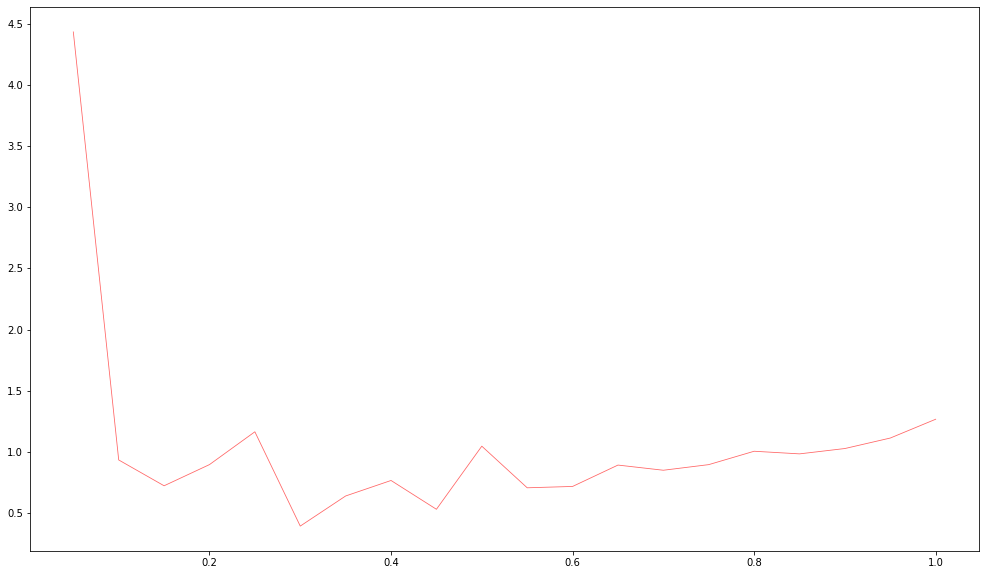

In [74]:
fig, ax = plt.subplots(figsize=(17,10))
ax.plot(nuevo_output[0], nuevo_output[1], lw = 0.8, alpha = 0.6, color = "red")

In [75]:
print("Minimo error: ", min(nuevo_output[1]))

Minimo error:  0.39451279822842156


In [76]:
a_r_optimo = nuevo_output[0][nuevo_output[1].index(min(nuevo_output[1]))]

In [77]:
print("a_r optimo: ", a_r_optimo)

a_r optimo:  0.3


In [78]:
def calibrar_a_n(n_particiones):
    A_n = min(100*sigma_n, 1)
    da = A_n/n_particiones
    
    eje_a_n = [da]
    error_n = []
    
    for i in range(n_particiones):
        
        start = time.time()
        
        JY = JYModel(eje_a_n[i], a_r_optimo, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, 
                     numero_simulaciones, n_0, r_0, i_0)
        
        JY.creacion_theta_n()
        JY.creacion_theta_r()
        
        JY.calcular_simulaciones()
        JY.curva_descuentos_aproximada_n()
        JY.curva_descuentos_aproximada_r()
        
        JY.creacion_matriz_A_B_n()
        JY.creacion_matriz_A_B_r()
        
        JY.calcular_curva_media_n()
        JY.curva_descuento_media_n()
        JY.curva_real_n()
        
        JY.calcular_curva_media_r()
        JY.curva_descuento_media_r()
        JY.curva_real_r()
        
        error_n.append(JY.calcular_error_n())
        
        eje_a_n.append(eje_a_n[i] + da)
        
        end = time.time()
        
        print("Iteracion: ", i+1)
        print("Tiempo: ", end-start)
        
    eje_a_n = eje_a_n[0:len(eje_a_n)-1]
    
    return [eje_a_n, error_n]

In [79]:
n_particiones = 20

output = calibrar_a_n(n_particiones)

Iteracion:  1
Tiempo:  23.233322620391846
Iteracion:  2
Tiempo:  28.037747383117676
Iteracion:  3
Tiempo:  24.82761311531067
Iteracion:  4
Tiempo:  27.73220443725586
Iteracion:  5
Tiempo:  26.699308156967163
Iteracion:  6
Tiempo:  34.72707557678223
Iteracion:  7
Tiempo:  26.0993013381958
Iteracion:  8
Tiempo:  26.69297456741333
Iteracion:  9
Tiempo:  25.21812343597412
Iteracion:  10
Tiempo:  26.505377531051636
Iteracion:  11
Tiempo:  27.80852508544922
Iteracion:  12
Tiempo:  27.64414954185486
Iteracion:  13
Tiempo:  32.79221034049988
Iteracion:  14
Tiempo:  27.58700728416443
Iteracion:  15
Tiempo:  26.98070764541626
Iteracion:  16
Tiempo:  28.928800106048584
Iteracion:  17
Tiempo:  26.37379217147827
Iteracion:  18
Tiempo:  25.840347051620483
Iteracion:  19
Tiempo:  25.300236463546753
Iteracion:  20
Tiempo:  24.645580768585205


In [80]:
def calcular_a_n_optimo(output):
    eje_a_n = output[0]
    errores_n = output[1]
    l = (np.mean(eje_a_n)/np.mean(errores_n))
    
    nuevos_errores_n = []
    
    for i in range(len(errores_n)):
        nuevos_errores_n.append(errores_n[i]*l + eje_a_n[i])
    
    return [eje_a_n, nuevos_errores_n]

In [81]:
nuevo_output = calcular_a_n_optimo(output)

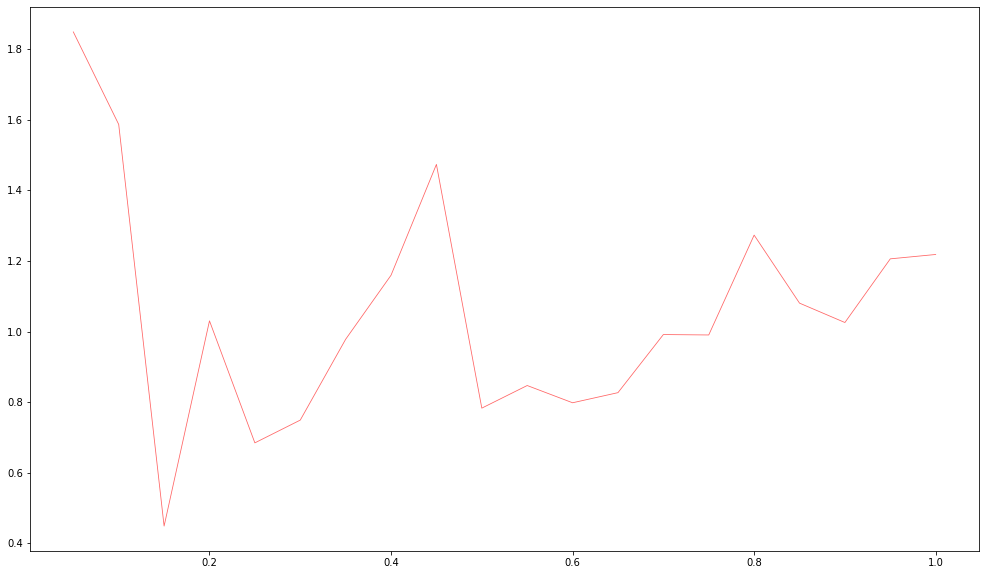

In [82]:
fig, ax = plt.subplots(figsize=(17,10))
ax.plot(nuevo_output[0], nuevo_output[1], lw = 0.8, alpha = 0.6, color = "red")

In [83]:
print("Minimo error: ", min(nuevo_output[1]))

Minimo error:  0.44814034693206517


In [84]:
a_n_optimo = nuevo_output[0][nuevo_output[1].index(min(nuevo_output[1]))]

In [85]:
print("a_n optimo: ", a_n_optimo)

a_n optimo:  0.15000000000000002


In [86]:
JY = JYModel(a_n_optimo, a_r_optimo, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, 
                 numero_simulaciones, n_0, r_0, i_0)

In [87]:
JY.creacion_theta_n()

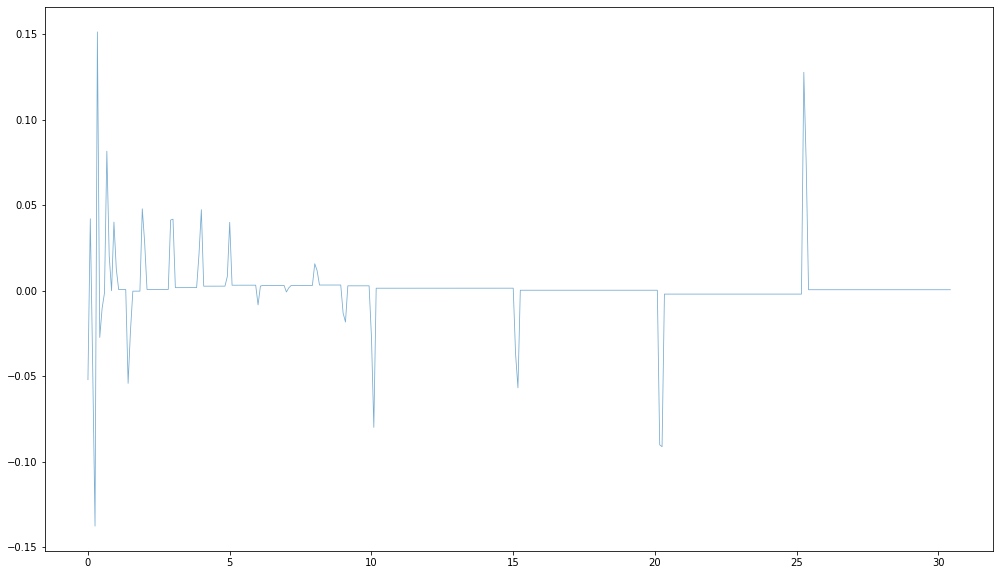

In [88]:
JY.graficar_theta_n()

In [89]:
JY.creacion_theta_r()

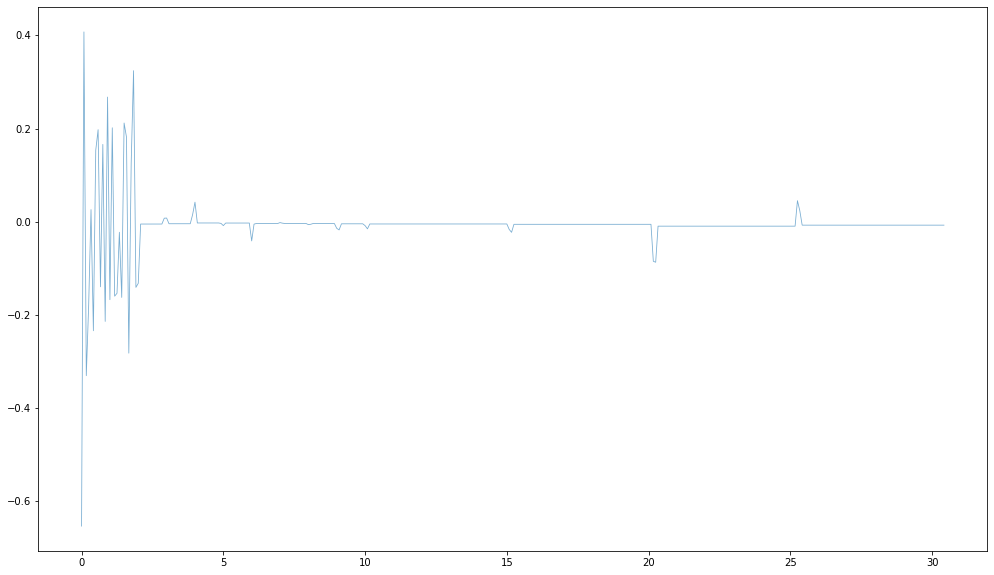

In [90]:
JY.graficar_theta_r()

In [91]:
JY.calcular_simulaciones()

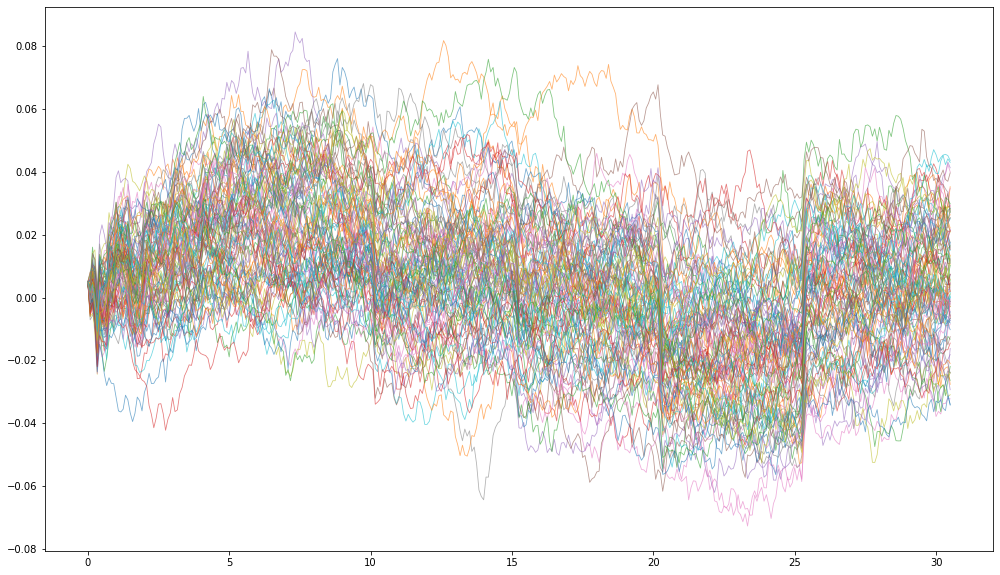

In [92]:
JY.graficar_n()

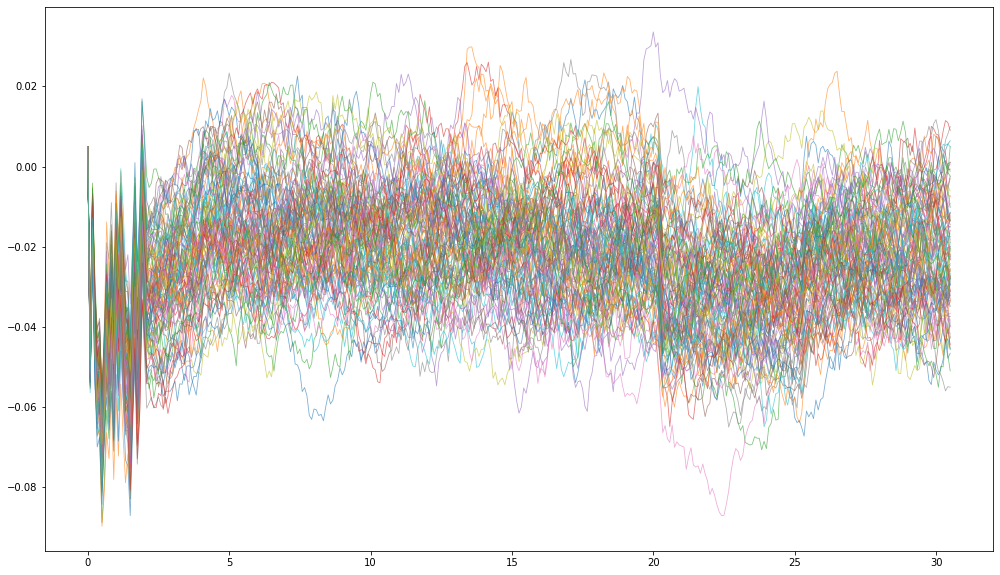

In [93]:
JY.graficar_r()

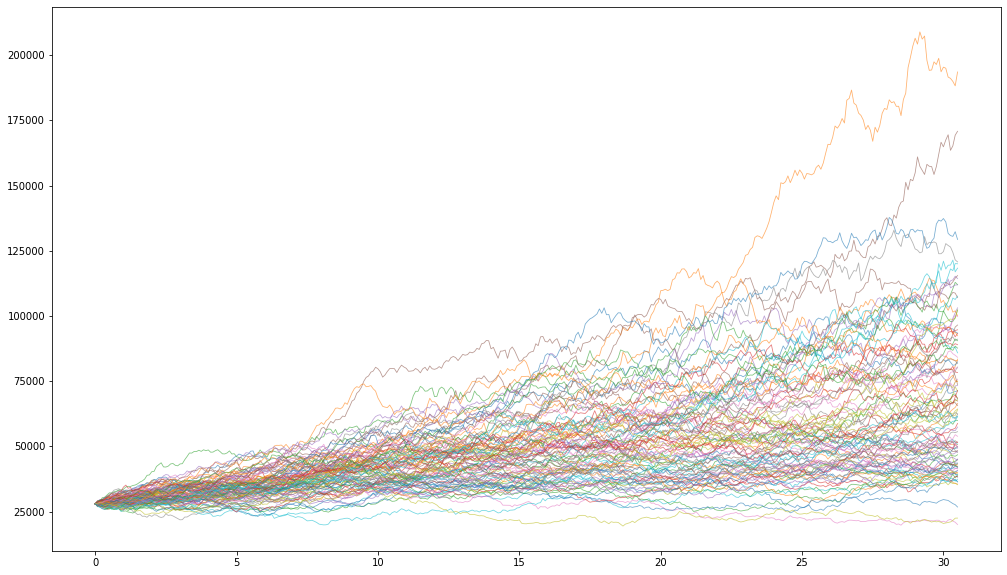

In [94]:
JY.graficar_i()

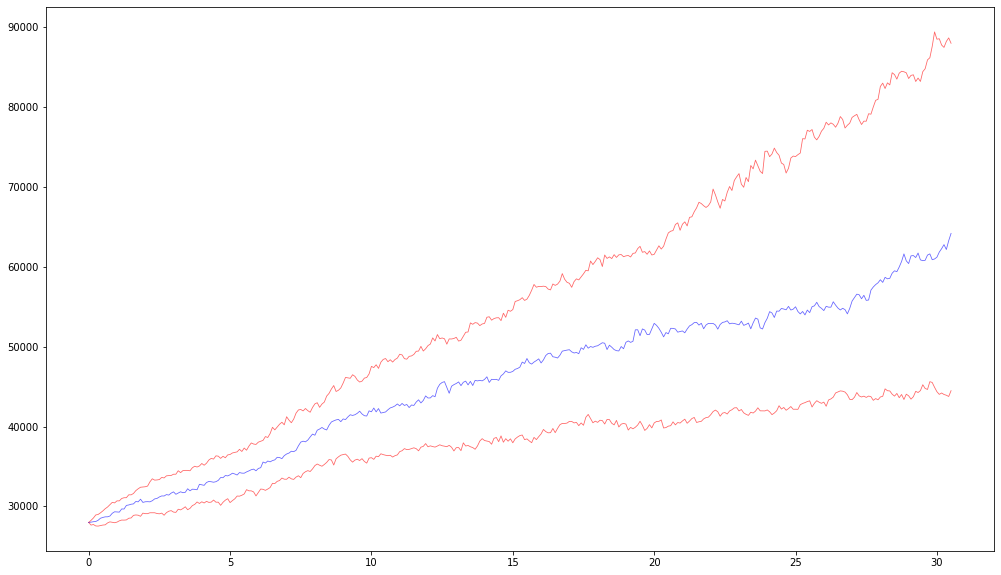

In [95]:
JY.graficar_intervalo_especifico(50)

In [96]:
JY.curva_descuentos_aproximada_n()

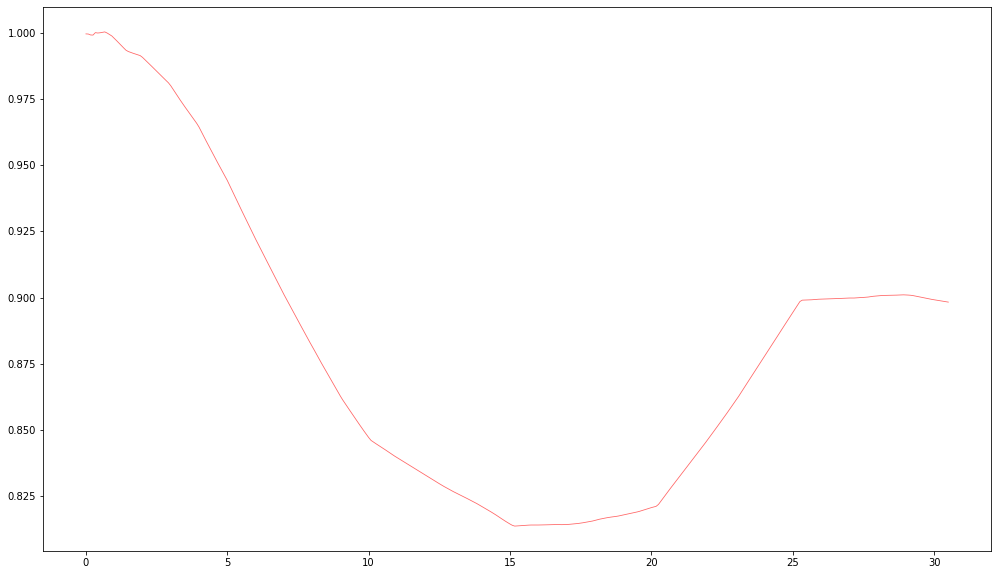

In [97]:
JY.graficar_curva_aproximada_n()

In [98]:
JY.curva_descuentos_aproximada_r()

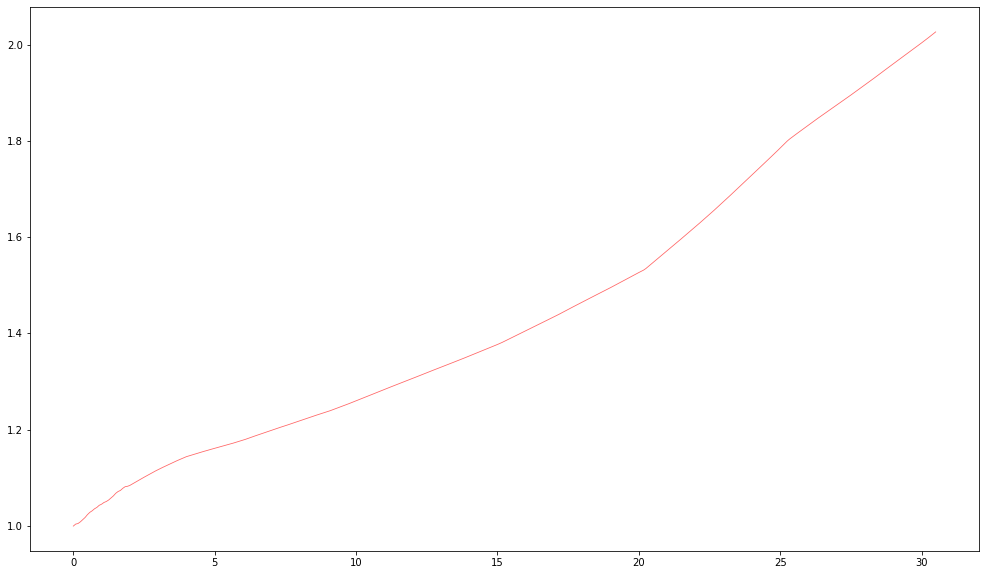

In [99]:
JY.graficar_curva_aproximada_r()

In [100]:
JY.creacion_matriz_A_B_n()

In [101]:
JY.creacion_matriz_A_B_r()

In [102]:
JY.curvas_descuentos_n_r()

In [103]:
JY.calcular_curva_media_n()

In [104]:
JY.curva_descuento_media_n()

In [105]:
JY.curva_real_n()

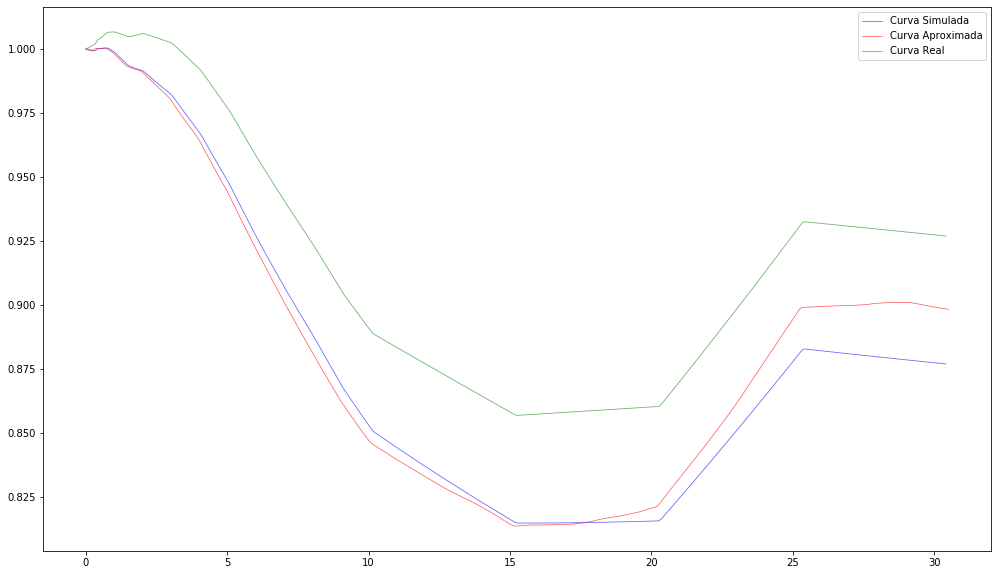

In [106]:
JY.graficar_comparacion_curvas_n()

In [107]:
JY.calcular_curva_media_r()

In [108]:
JY.curva_descuento_media_r()

In [109]:
JY.curva_real_r()

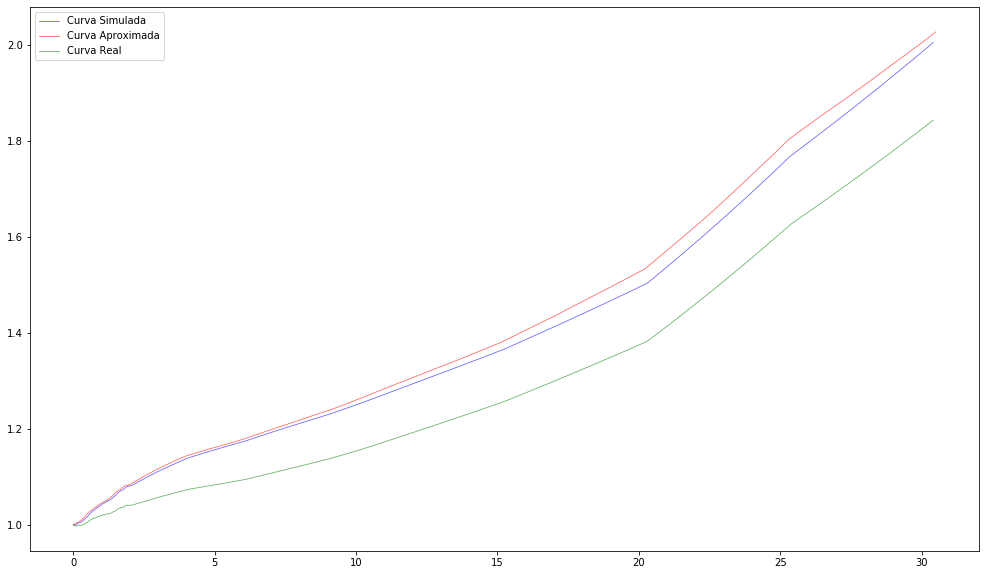

In [110]:
JY.graficar_comparacion_curvas_r()

In [111]:
JY.calcular_error_r()

0.019056732716750055

In [112]:
JY.calcular_error_n()

0.0073571887798576365